In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call TBATS model (Trigonometric, Box-Cox transformation, ARMA errors, Trend, and Seasonal components)
from sktime.forecasting.tbats import TBATS

import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_imputed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# # print first two rows
# inflow_data.head(3)

In [2]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

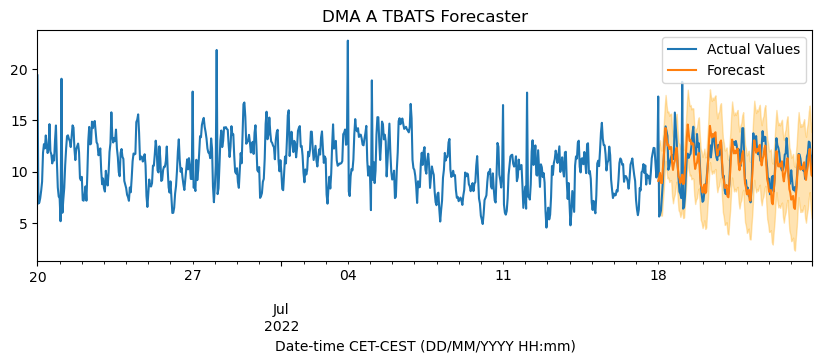

Performance indicators
DMA A TBATS 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.73            8.21             1.03           10.97 



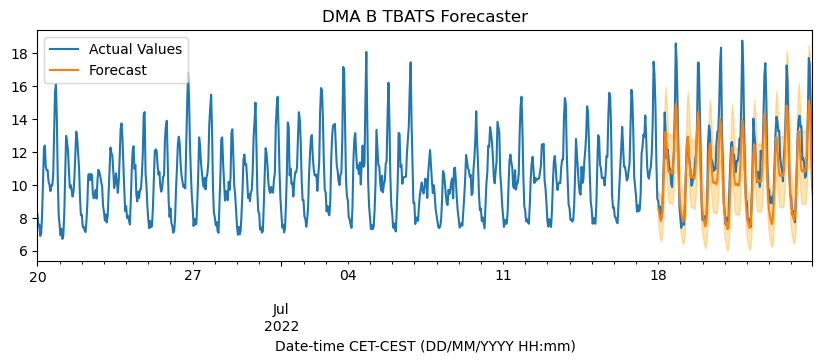

Performance indicators
DMA B TBATS 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.82            3.70             1.01           5.52 



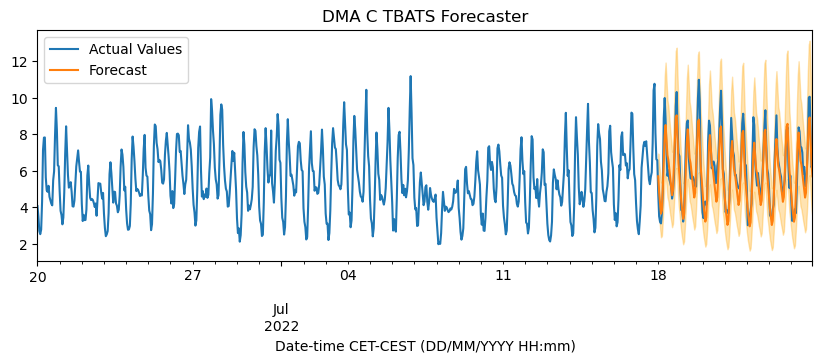

Performance indicators
DMA C TBATS 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.74            2.32             0.63           3.69 



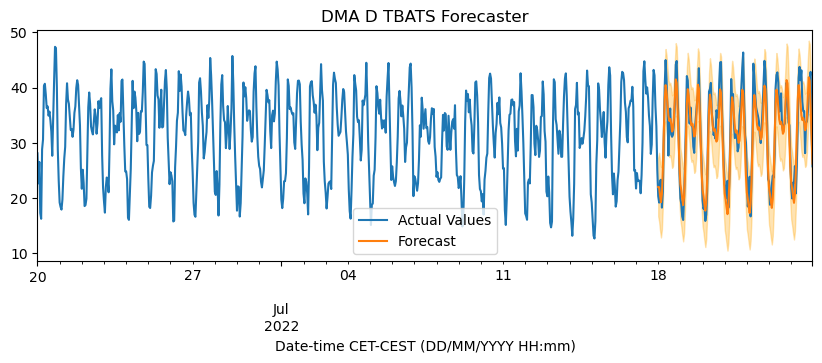

Performance indicators
DMA D TBATS 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.33            7.20             2.50           12.04 



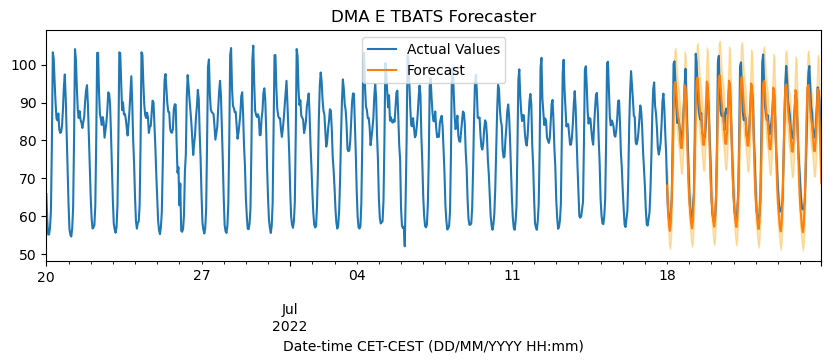

Performance indicators
DMA E TBATS 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.76            12.81             3.01           18.58 



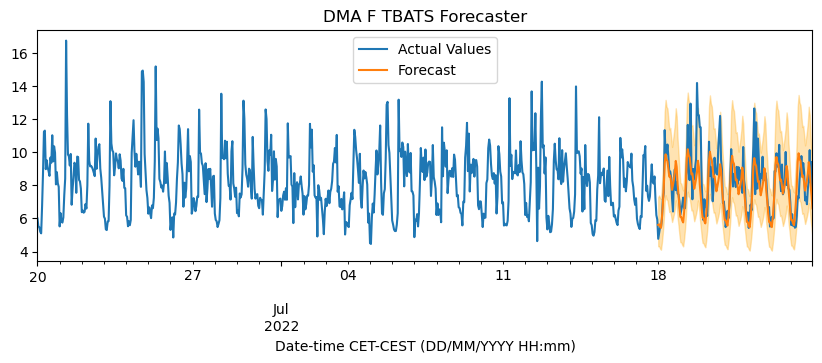

Performance indicators
DMA F TBATS 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.55            2.01             0.96           3.52 



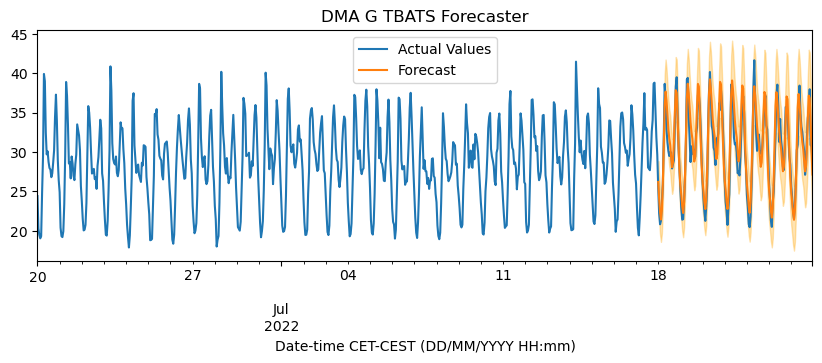

Performance indicators
DMA G TBATS 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.27            3.69             1.41           6.37 



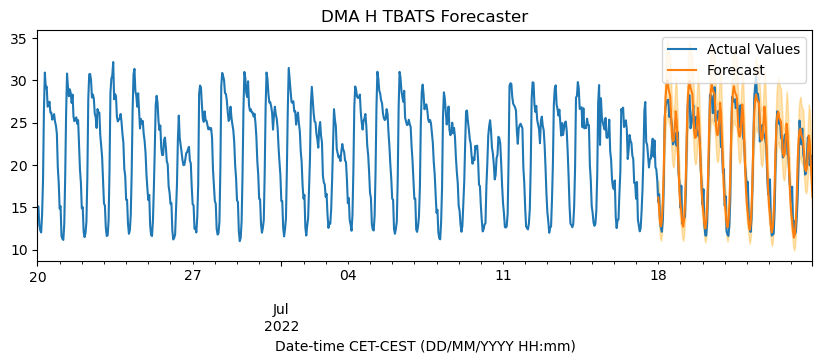

Performance indicators
DMA H TBATS 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.36            3.77             1.42           6.55 



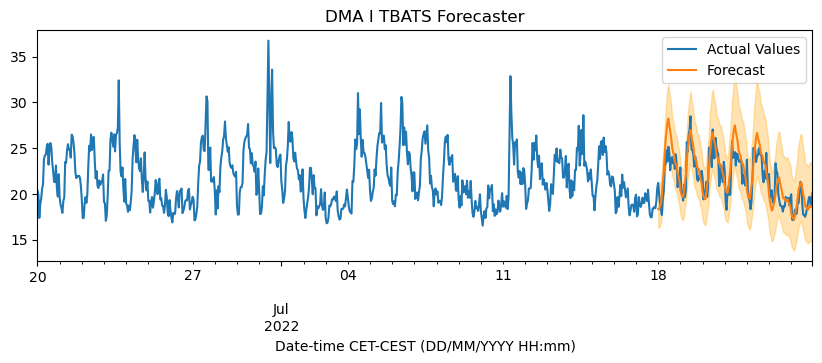

Performance indicators
DMA I TBATS 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.75            4.28             1.13           7.16 



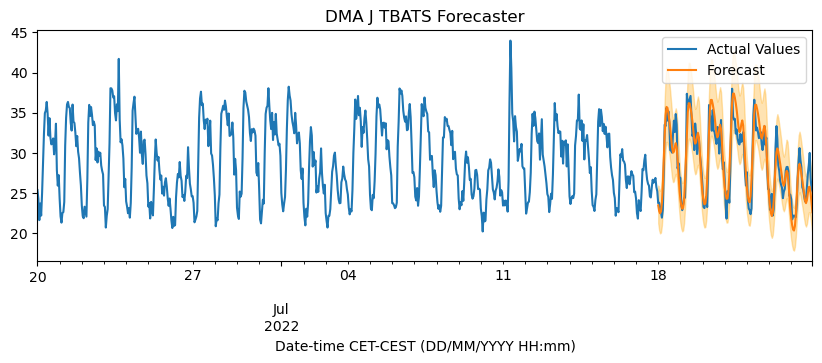

Performance indicators
DMA J TBATS 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.52            3.84             1.43           6.80 



In [3]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2022-06-20'
end = '2022-07-24'

# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    # fill missing values with interpolation technique
    #tseries_df.interpolate(limit_direction='both',inplace=True)

    # # plot original and interpolated time series for selected dma
    # fig, ax = plt.subplots()
    # tseries_df.plot(label='Interpolated')
    # inflow_data[dma][start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1, label='Original')
    # plt.title(dma_list[dict_dma[dma]] + ". " + dma_descripton[dict_dma[dma]] +". "+ str(users_supplied[dict_dma[dma]]) + " users supplied. ")
    # plt.xlabel("Date")
    # plt.ylabel("L/s")
    # plt.legend()
    # plt.show()

    y = tseries_df
    y_train, y_test = temporal_train_test_split(y, test_size = 168)

    #Naive Forecaster
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = NaiveForecaster(strategy = 'mean')
    forecaster.fit(y_train)
    # results of naive forecaster
    y_pred_naive = forecaster.predict(fh)

    # #print results (optional)
    # fig, ax = plt.subplots(figsize = (10,3))
    # tseries_df.plot(title = 'Naive Forecaster', ax = ax)
    # y_pred_naive.plot(ax = ax)
    # ax.legend(['Actual Values', 'Forecast'])
    # plt.show()

    # implement tbats model    
    forecaster = TBATS(sp = [6,12,24,168], n_jobs = 12)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)

    y_pred_interval = forecaster.predict_interval(fh,coverage=0.95)

    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df.plot(title = dma[:5]+' TBATS Forecaster', xlabel = '', ax = ax)
    y_pred.plot(ax = ax)
    ax.fill_between(y_pred.index, y_pred_interval[dma][0.95]['lower'], y_pred_interval[dma][0.95]['upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    print('Performance indicators')
    df = print_metrics(y_test, y_pred, dma[:5]+' TBATS 4-Weeks',return_df=1)
    results_df = pd.concat([results_df, df])
    # print_metrics(y_test, y_pred_naive, 'Naive Forecaster')

In [4]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A TBATS 4-Weeks,1.733,8.206,1.032,10.972
DMA B TBATS 4-Weeks,0.817,3.695,1.005,5.517
DMA C TBATS 4-Weeks,0.738,2.320,0.629,3.687
DMA D TBATS 4-Weeks,2.333,7.205,2.502,12.040
DMA E TBATS 4-Weeks,2.762,12.808,3.014,18.584
DMA F TBATS 4-Weeks,0.547,2.010,0.964,3.521
DMA G TBATS 4-Weeks,1.273,3.691,1.408,6.372
DMA H TBATS 4-Weeks,1.363,3.769,1.417,6.549
DMA I TBATS 4-Weeks,1.749,4.279,1.132,7.160
DMA J TBATS 4-Weeks,1.522,3.845,1.434,6.800


In [5]:
print(f"{results_df['Total'].sum() :.2f}")

81.20


In [6]:
print(f"{results_df.drop('DMA E TBATS 4-Weeks')['Total'].sum() :.2f}")

62.62
